# SunPy/PySpedas Planning

1 h 20 minutes

## Packages

- sunpy
- pyspedas
- plasmapy (maybe?)
- stixpy
- solarmach (for backmapping)
- sunpy-soar (maybe for in situ solo data? or just use cdaweb)

## Instruments

- PSP
    - Imaging:
        - WISPR
    - In situ:
        - FIELDS
        - SWEAP
        - ISOIS
- STEREO
    - Imaging
        - SECCHI
- SDO
    - Imaging:
        - AIA
        - HMI
- Solar Orbiter
    - Imaging
        - EUI (???)
    - In situ
        - MAG
     
- We don't have SolO EUV data during this period but we do have STEREO data and they are at approximately the same longitude at the time of the event.
     
## Analysis

- Synoptic map composed of STEREO + AIA (+EUI??)
- Comparison between field models and observations
    - T89 field model (e.g. dependent on Kp data)
    - Get position from spacecraft ephemeris
    - Field model at that position
    - Comparison to what is measured
    - Do the field measurements diverge as a disturbance happens? 
- Magnetic field extrapolation to connect spacecraft position to solar surface
    - This requires `sunkit-magex` 
- PlasmaPy comparison
    - Calculate plasma parameters from observations
    - leads into the next session on PlasmaPy/SpacePy
 
## What's the story we want tell?

- See disturbance on the sun in
    - xrays (GOES + STIX)
    - EUV  (AIA, SECCHI)
- See corresponding changes in *in situ* data
    - MAG (PSP)
    - EPD (Solar Orbiter)
    - Load both with pyspedas
    - Do some basic visualization
- Where is the origin?
    - Build synoptic view in EUV with AIA+SECCHI (sunpy)
    - Backmap from PSP and SolO location to solar surface (solarmach)
- Is there a corresponding disturbance in the solar wind?
    - visible (WISPR)
    - Reproject to full FOV with corresponding AIA image

## Notes on making sunpy/pyspedas talk

### Installation

- For some reason I had to install HDF5 explicitly with conda
- Installing pyspedas installs `tables` which either doesn't have wheels or does not have macOS ARM wheels for Python 3.11
- Without an HDF5 install, this step fails.

### Data download

- There's annoyingly no Solar Orbiter Mag data from this time
- Is there some other *in situ* dataset we could look at?

### Analysis

- Could we use solarmach to do the backmapping?

In [122]:
import astropy.time
import astropy.units as u
import numpy as np
import sunpy_soar
import sunpy.map

import solarmach

from sunpy.net import Fido, attrs as a
from sunpy.timeseries import TimeSeries

## Spacecraft Location

In [139]:
time_start = astropy.time.Time('2023-03-20 12:00:00')
time_end = astropy.time.Time('2023-03-20 16:00:00')

In [95]:
body_list = ['SDO', 'PSP', 'Solar Orbiter', 'STEREO-B']
smach = solarmach.SolarMACH(time_start.iso, body_list, vsw_list=[400, 400, 400, 400])

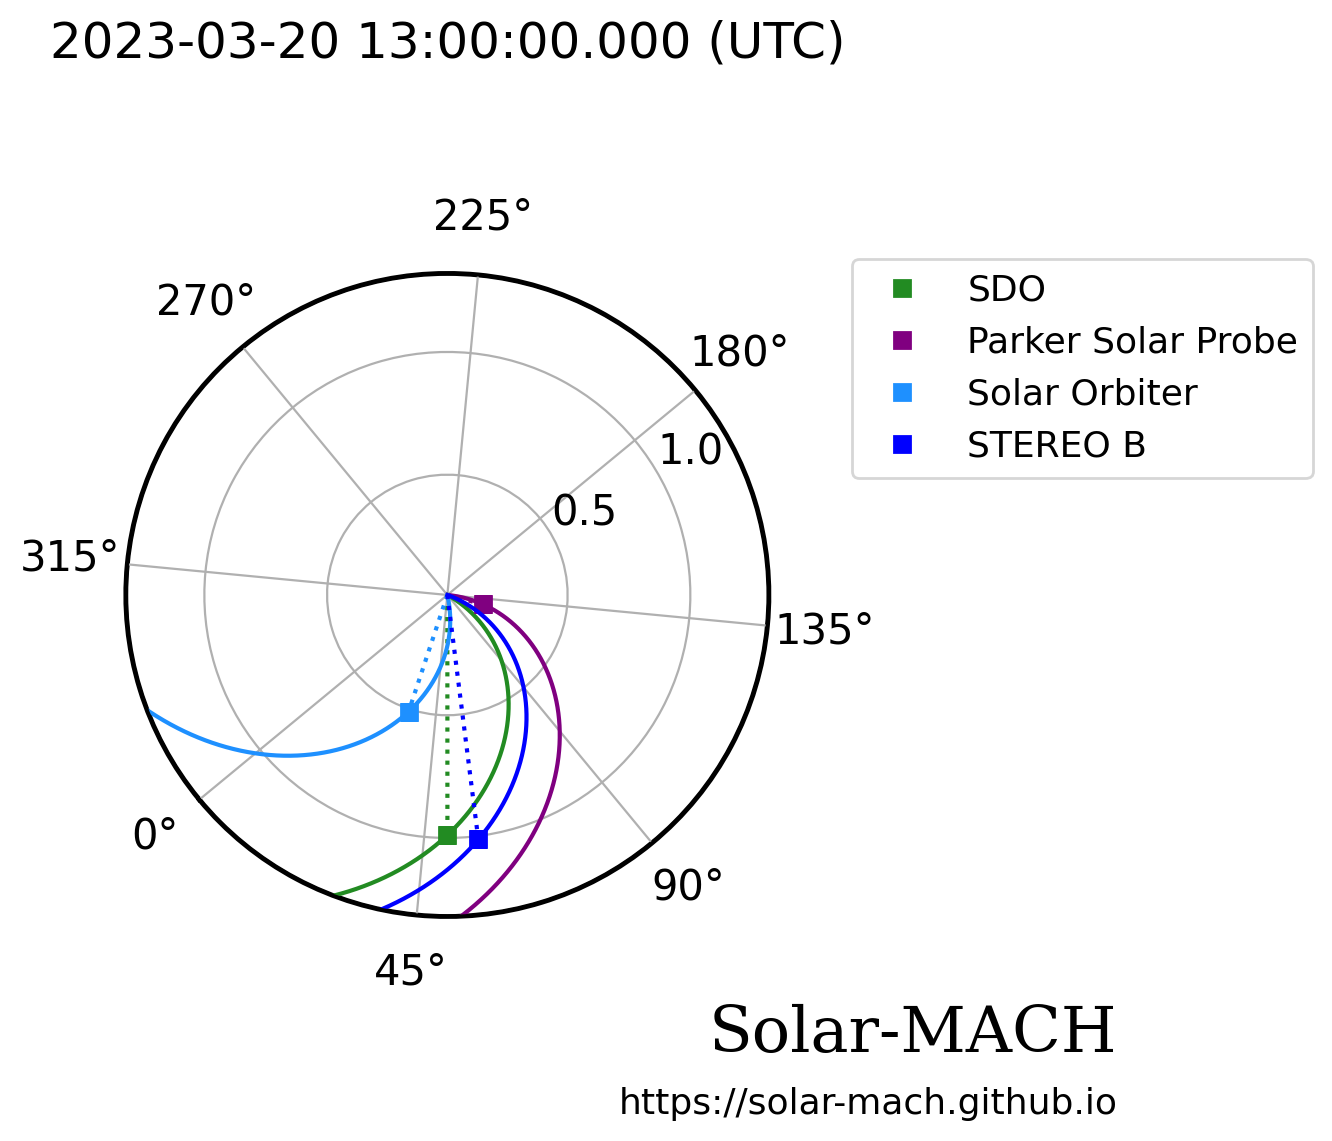

In [96]:
smach.plot(figsize=(7,7), plot_sun_body_line=True)

## Data Download

In [142]:
time_query = a.Time(time_start, time_end)

Use the GOES lightcurve to pare down what we're looking at

In [159]:
q = Fido.search(time_query, a.Instrument.wispr, a.Level(3))

In [161]:
files = Fido.fetch(q, path='data/{instrument}/{file}')

Files Downloaded:   0%|                                                                                                            | 0/48 [00:00<?, ?file/s]
psp_l3_wispr_20230320t130015_v1_1221.fits:   0%|                                                                                | 0.00/3.95M [00:00<?, ?B/s]


psp_l3_wispr_20230320t130802_v1_1221.fits:   0%|                                                                                | 0.00/3.95M [00:00<?, ?B/s]




psp_l3_wispr_20230320t131526_v1_1221.fits:   0%|                                                                                | 0.00/3.95M [00:00<?, ?B/s]

psp_l3_wispr_20230320t130203_v1_2222.fits:   0%|                                                                                | 0.00/3.95M [00:00<?, ?B/s]



psp_l3_wispr_20230320t130927_v1_2222.fits:   0%|                                                                                | 0.00/3.95M [00:00<?, ?B/s]
psp_l3_wispr_20230320t130015_v1_1221.fits:   7%|

In [ ]:
wispr_inner_maps = 

In [68]:
goes_query = a.Instrument.xrs & a.goes.SatelliteNumber(18) & a.Resolution('flx1s')
q = Fido.search(time_query, goes_query)

In [69]:
ts_goes = TimeSeries(Fido.fetch(q), concatenate=True)

Files Downloaded: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.88file/s]


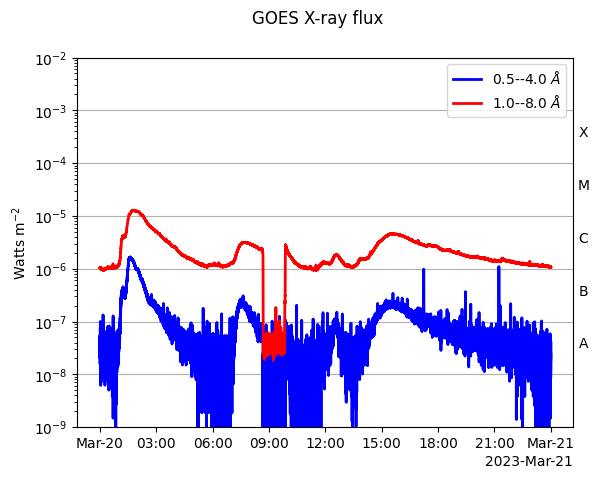

In [70]:
ts_goes.peek()

In [46]:
q = Fido.search(
    time_query,
    a.cdaweb.Dataset.psp_fld_l2_mag_rtn_1min | a.cdaweb.Dataset.solo_,
)

In [47]:
q

<sunpy.net.fido_factory.UnifiedResponse object at 0x151407690>
Results from 2 Providers:

1 Results from the CDAWEBClient:
Source: https://cdaweb.gsfc.nasa.gov/index.html

        Dataset                Start time               End time       
----------------------- ----------------------- -----------------------
PSP_FLD_L2_MAG_RTN_1MIN 2023-03-24 00:00:30.000 2023-03-24 23:59:30.000

0 Results from the CDAWEBClient:
Source: https://cdaweb.gsfc.nasa.gov/index.html

Dataset Start time End time
------- ---------- --------

In [31]:
files_psp = Fido.fetch(q)

Files Downloaded:   0%|                                                                    | 0/1 [00:00<?, ?file/s]
psp_fld_l2_mag_rtn_1min_20230324_v02.cdf:   0%|                                        | 0.00/94.6k [00:00<?, ?B/s]
Files Downloaded: 100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.99file/s]


In [36]:
ts_psp = TimeSeries(files_psp, concatenate=False)

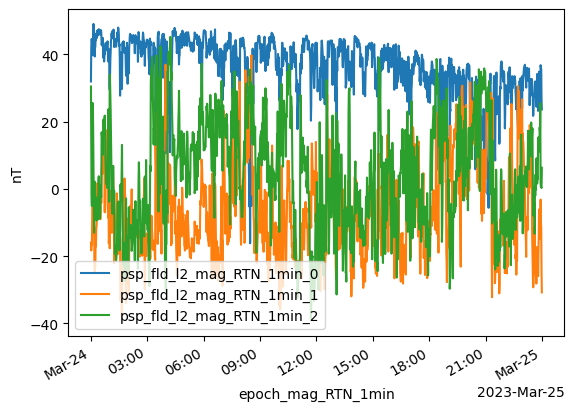

In [42]:
ts_psp[0].peek()

In [45]:
ts_psp[0].meta.metas

[{'TITLE': 'PSP FIELDS Fluxgate Magnetometer (MAG) data',
  'Project': 'PSP',
  'Discipline': ['Solar Physics>Heliospheric Physics',
   'Space Physics>Interplanetary Studies'],
  'Source_name': 'PSP_FLD>Parker Solar Probe FIELDS',
  'Descriptor': 'MAG_RTN_1min>Fluxgate Magnetometer data in RTN coordinates',
  'Data_type': 'L2>Level 2 Data',
  'Data_version': '02',
  'TEXT': ['PSP FIELDS Fluxgate Magnetometer data. Time resolution varies with instrument mode, ranging from 2.3-292.9 samples/sec, corresponding to 2-256 samples per 0.874 seconds (0.874 = 2^25 / 38.4 MHz, see reference [2]).',
   'The Magnetometer has 4 ranges - +/-1024, +/-4096, +/-16,384, +/-65,536 nT, selected by the ranging algorithm, based on the ambient magnetic field. Precision is +/- 15 bits, based on the 16-bit ADC.',
   'References:',
   '1. Fox, N.J., Velli, M.C., Bale, S.D. et al. Space Sci Rev (2016) 204: 7. https://doi.org/10.1007/s11214-015-0211-6',
   '2. Bale, S.D., Goetz, K., Harvey, P.R. et al. Space Sci 

In [143]:
q = Fido.search(time_query, a.Instrument.eui, a.soar.Product('eui-fsi304-image'), a.Level(2))

In [144]:
q

<sunpy.net.fido_factory.UnifiedResponse object at 0x169a17810>
Results from 1 Provider:

36 Results from the SOARClient:

Instrument   Data product   Level        Start time               End time        Filesize SOOP Name
                                                                                   Mbyte            
---------- ---------------- ----- ----------------------- ----------------------- -------- ---------
       EUI eui-fsi304-image    L2 2023-03-20 13:00:20.179 2023-03-20 13:00:30.179    3.704      none
       EUI eui-fsi304-image    L2 2023-03-20 13:05:20.179 2023-03-20 13:05:30.179    3.652      none
       EUI eui-fsi304-image    L2 2023-03-20 13:10:20.180 2023-03-20 13:10:30.180    3.738      none
       EUI eui-fsi304-image    L2 2023-03-20 13:15:20.180 2023-03-20 13:15:30.180     3.66      none
       EUI eui-fsi304-image    L2 2023-03-20 13:20:20.181 2023-03-20 13:20:30.181    3.718      none
       EUI eui-fsi304-image    L2 2023-03-20 13:25:20.183 2023-03-20 13:25:30.183    4.314      none
       EUI eui-fsi304-image    L2 2023-03-20 13:30:20.182 2023-03-20 13:30:30.182    3.707      none
       EUI eui-fsi304-image    L2 2023-03-20 13:35:20.184 2023-03-20 13:35:30.184    3.695      none
       EUI eui-fsi304-image    L2 2023-03-20 13:40:20.183 2023-03-20 13:40:30.183    3.637      none
       EUI eui-fsi304-image    L2 2023-03-20 13:45:20.185 2023-03-20 13:45:30.185    3.666      none
       EUI eui-fsi304-image    L2 2023-03-20 13:50:20.184 2023-03-20 13:50:30.184    3.787      none
       EUI eui-fsi304-image    L2 2023-03-20 13:55:20.187 2023-03-20 13:55:30.187    3.658      none
       EUI eui-fsi304-image    L2 2023-03-20 14:00:20.185 2023-03-20 14:00:30.185    3.747      none
       EUI eui-fsi304-image    L2 2023-03-20 14:05:20.185 2023-03-20 14:05:30.185    4.162      none
       EUI eui-fsi304-image    L2 2023-03-20 14:10:20.186 2023-03-20 14:10:30.186    3.617      none
       EUI eui-fsi304-image    L2 2023-03-20 14:15:20.189 2023-03-20 14:15:30.189    3.695      none
       EUI eui-fsi304-image    L2 2023-03-20 14:20:20.187 2023-03-20 14:20:30.187    3.891      none
       EUI eui-fsi304-image    L2 2023-03-20 14:25:20.188 2023-03-20 14:25:30.188    3.724      none
       EUI eui-fsi304-image    L2 2023-03-20 14:30:20.188 2023-03-20 14:30:30.188    3.675      none
       EUI eui-fsi304-image    L2 2023-03-20 14:35:20.189 2023-03-20 14:35:30.189    3.686      none
       EUI eui-fsi304-image    L2 2023-03-20 14:40:20.189 2023-03-20 14:40:30.189    3.686      none
       EUI eui-fsi304-image    L2 2023-03-20 14:45:20.190 2023-03-20 14:45:30.190     4.02      none
       EUI eui-fsi304-image    L2 2023-03-20 14:50:20.190 2023-03-20 14:50:30.190    3.934      none
       EUI eui-fsi304-image    L2 2023-03-20 14:55:20.191 2023-03-20 14:55:30.191    3.767      none
       EUI eui-fsi304-image    L2 2023-03-20 15:00:20.191 2023-03-20 15:00:30.191    3.684      none
       EUI eui-fsi304-image    L2 2023-03-20 15:05:20.194 2023-03-20 15:05:30.194    3.776      none
       EUI eui-fsi304-image    L2 2023-03-20 15:10:20.192 2023-03-20 15:10:30.192    3.586      none
       EUI eui-fsi304-image    L2 2023-03-20 15:15:20.193 2023-03-20 15:15:30.193    3.695      none
       EUI eui-fsi304-image    L2 2023-03-20 15:20:20.194 2023-03-20 15:20:30.194    3.715      none
       EUI eui-fsi304-image    L2 2023-03-20 15:25:20.194 2023-03-20 15:25:30.194    3.787      none
       EUI eui-fsi304-image    L2 2023-03-20 15:30:20.194 2023-03-20 15:30:30.194    3.928      none
       EUI eui-fsi304-image    L2 2023-03-20 15:35:20.195 2023-03-20 15:35:30.195    3.816      none
       EUI eui-fsi304-image    L2 2023-03-20 15:40:20.195 2023-03-20 15:40:30.195    3.658      none
       EUI eui-fsi304-image    L2 2023-03-20 15:45:20.199 2023-03-20 15:45:30.199     4.13      none
       EUI eui-fsi304-image    L2 2023-03-20 15:50:20.197 2023-03-20 15:50:30.197    3.989      none
       EUI eui-fsi304-image    L2 2023-0

In [145]:
files = Fido.fetch(q, path='data/{instrument}/{file}')

Files Downloaded:  58%|█████████████████████████████████████████████████████████▊                                         | 21/36 [00:01<00:01, 13.13file/s]




solo_L2_eui-fsi304-image_20230320T150020191_V01.fits:   0%|                                                                     | 0.00/3.68M [00:00<?, ?B/s]
solo_L2_eui-fsi304-image_20230320T150520194_V01.fits:   0%|                                                                     | 0.00/3.78M [00:00<?, ?B/s]

solo_L2_eui-fsi304-image_20230320T152020194_V01.fits:   0%|                                                                     | 0.00/3.72M [00:00<?, ?B/s]



solo_L2_eui-fsi304-image_20230320T151520193_V01.fits:   0%|                                                                     | 0.00/3.70M [00:00<?, ?B/s]


solo_L2_eui-fsi304-image_20230320T151020192_V01.fits:   0%|                                                                     | 0.00/3.59M [00:00<?, ?B/s]




solo_L2_eui-fsi304-image_20230320T150020191_

In [162]:
eui_maps = sunpy.map.Map('data/EUI/*.fits')

In [ ]:
bl_corner = (-2000,-2000)*u.arcsec
tr_corner = (2000,2000)*u.arcsec
eui_maps_cropped = []
for m in eui_maps:
    blc = Sky

In [147]:
from astropy.visualization import ImageNormalize, SqrtStretch

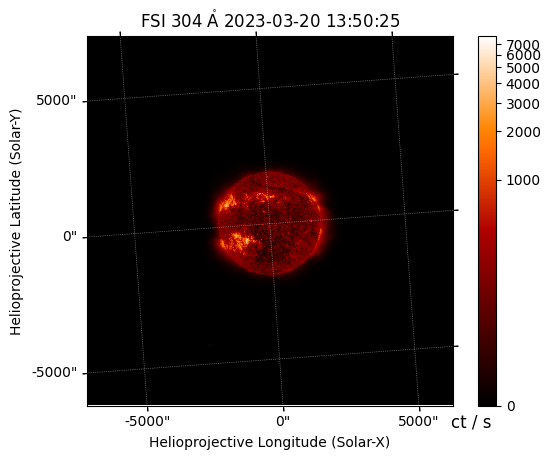

In [148]:
eui_maps[10].peek()

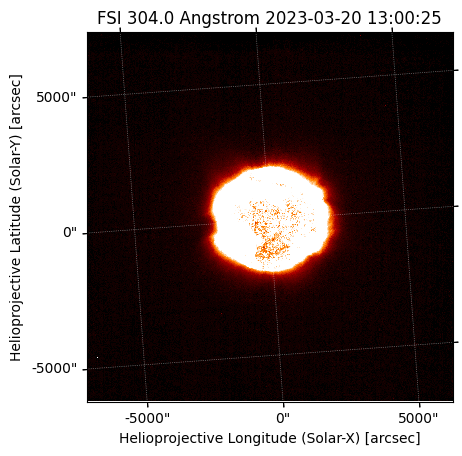

In [152]:
ani = eui_maps.plot(
    norm=ImageNormalize(stretch=SqrtStretch(), vmin=0, vmax=1e2))

In [153]:
from IPython.display import HTML

In [154]:
HTML(ani.to_jshtml())